In [1]:
import numpy as np
import jdc
import random
import matplotlib.pyplot as plt
import math

In [2]:
class Road_Alignment:
    def __init__(self, data, pop_size, max_generations=100, tournament_size=5, crossover_probability=0.5, mutation_probability=0.1, elite_percentage=0.4, convergence_threshold=1e-15, no_improvement_threshold=10):
        self.data = data
        self.shape = data.shape
        self.pop_size = pop_size
        self.population = None
        self.tournament_size = tournament_size
        self.crossover_probability = crossover_probability
        self.mutation_probability = mutation_probability
        self.convergence_threshold = convergence_threshold
        self.no_improvement_threshold = no_improvement_threshold
        self.elite_percentage = elite_percentage
        self.max_generations = max_generations

In [3]:
%%add_to Road_Alignment
def initialize_population(self):
    self.population = []
    for i in range(self.pop_size):
        chromosome = [(i,random.randint(0,self.data.shape[0] - 1)) for i in range(0,self.data.shape[1])]
        self.population.append(chromosome)

In [4]:
%%add_to Road_Alignment
def calculate_fitness(self,chromosome):
    total_cost = 0.0 
    for i in range(len(chromosome) - 1):
        x1, y1 = chromosome[i]
        x2, y2 = chromosome[i + 1]
        if abs(x1 - x2) == 1 and abs(y1 - y2) <= 1:
            road_cost = self.data[y1][x1]
            total_cost += road_cost
        else:
            distance_cost = (x2 - x1)**2 + (y2 - y1)**2
            total_cost += distance_cost

    return total_cost

In [5]:
%%add_to Road_Alignment
def parent_tournament_selection(self):
    tournament_candidates = random.sample(self.population, self.tournament_size)
    winner = min(tournament_candidates, key=lambda ind: self.calculate_fitness(ind))
    tournament_candidates = random.sample(self.population, self.tournament_size)
    runner_up = min(tournament_candidates, key=lambda ind: self.calculate_fitness(ind))
    return winner, runner_up

In [6]:
%%add_to Road_Alignment
def uniform_crossover(self,parent1, parent2):
    offspring1 = np.zeros_like(parent1)
    offspring2 = np.zeros_like(parent2)
    for i in range(len(parent1)):
        if np.random.rand() < self.crossover_probability:
            offspring1[i] = parent1[i]
            offspring2[i] = parent2[i]
        else:
            offspring1[i] = parent2[i]
            offspring2[i] = parent1[i]
    return offspring1, offspring2

In [7]:
%%add_to Road_Alignment
def mutate(self,chromosome):
    mutated_chromosome = np.copy(chromosome)

    for i in range(len(chromosome)):
        if np.random.rand() < self.mutation_probability:
            x, y = mutated_chromosome[i]
            y = np.clip(y + np.random.randint(-2, 2), 0, self.data.shape[0] - 1)
            mutated_chromosome[i] = (x, y)
    offspring = list(mutated_chromosome)
    return offspring

In [8]:
%%add_to Road_Alignment
def generate_offspring(self, num_offspring):
    offsprings = []
    while len(offsprings) < num_offspring:
        parent1 = self.parent_tournament_selection()[0]
        parent2 = self.parent_tournament_selection()[1]
        offspring1, offspring2 = self.uniform_crossover(parent1, parent2)
        
        offspring1 = self.mutate(offspring1)
        offspring2 = self.mutate(offspring2)
        offsprings.extend([offspring1, offspring2])
    return offsprings[:num_offspring]

In [9]:
%%add_to Road_Alignment
def elitism_survival_selection(self, fitness_values, offsprings, num_elite):
    sorted_indices = np.argsort(fitness_values)
    elite_indices = sorted_indices[:num_elite]
    elite_individuals = [self.population[i] for i in elite_indices]
    new_generation = elite_individuals + offsprings
    return new_generation

In [10]:
%%add_to Road_Alignment
def terminate(self,best_fitness_values):
    if self.has_converged(best_fitness_values):
        return True
    if self.no_improvement(best_fitness_values):
        return True
    return False

In [11]:
%%add_to Road_Alignment
def has_converged(self,best_fitness_values):
    if len(best_fitness_values) > 1:
        last_best_fitness = best_fitness_values[-2]
        current_best_fitness = best_fitness_values[-1]
        change_in_fitness = np.abs(current_best_fitness - last_best_fitness)
        print("has_converged:", change_in_fitness < self.convergence_threshold)
        return change_in_fitness < self.convergence_threshold
    return False

In [12]:
%%add_to Road_Alignment
def no_improvement(self,best_fitness_values):
    if len(best_fitness_values) > self.no_improvement_threshold:
        recent_best_fitness = best_fitness_values[-self.no_improvement_threshold:]
        improvement_check = all(recent_best_fitness[i] >= recent_best_fitness[i + 1] for i in range(self.no_improvement_threshold - 1))   
        print("no_improvement",improvement_check)
        
        return improvement_check
    return False

In [13]:
%%add_to Road_Alignment
def extract_solution(self,population, fitness_values):
    best_index = np.argmin(fitness_values)
    best_individual = population[best_index]
    return best_individual

In [14]:
%%add_to Road_Alignment
def visualize_map(self):
    plt.imshow(self.data, cmap='YlGn', interpolation='nearest')
    cbar = plt.colorbar()
    plt.gca().invert_yaxis()
    cbar.set_label('Roughness Level')
    plt.title('Map Roughness')
#     plt.show()
    return plt

In [15]:
%%add_to Road_Alignment
def visualize_chromosome(self, plt,chromosome):
    for i in range(len(chromosome) - 1):
        x1, y1 = chromosome[i]
        x2, y2 = chromosome[i + 1]
        if abs(x1 - x2) == 1 and abs(y1 - y2) <= 1:
            plt.plot([x1, x2], [y1, y2], linestyle='-',color='black')
        else:
            plt.plot([x1, x2], [y1, y2], linestyle='-',color='red')
    plt.title('chromosome')
    plt.show()

In [21]:
data = np.load('map.npy')
ra = Road_Alignment(data, pop_size=500, max_generations=120, tournament_size=5, crossover_probability=0.6, mutation_probability=0.1, elite_percentage=0.4, convergence_threshold=1e-15, no_improvement_threshold=10)  
ra.initialize_population()

In [22]:
average_fitness_values = []
best_fitness_values = []
for generation in range(ra.max_generations):
    fitness_values = [ra.calculate_fitness(ind) for ind in ra.population]
    best_fitness_values.append(min(fitness_values))
    average_fitness_values.append(np.mean(fitness_values))
    num_elite = int(len(ra.population) * ra.elite_percentage)
    offsprings = ra.generate_offspring(len(ra.population) - num_elite)
    ra.population = ra.elitism_survival_selection(fitness_values, offsprings, num_elite)
#     if ra.terminate(average_fitness_values):
#         print(generation)
#         break

63.0


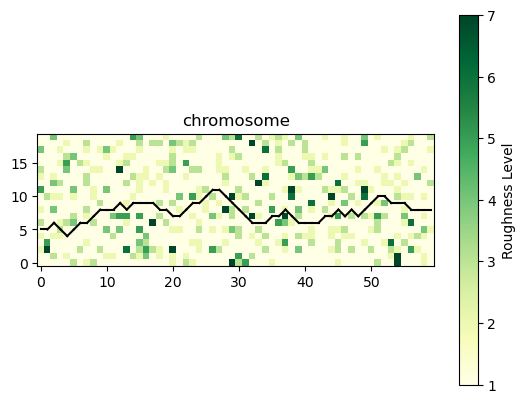

In [23]:
best_individual = ra.extract_solution(ra.population, fitness_values)
print(ra.calculate_fitness(best_individual))
plt = ra.visualize_map()
ra.visualize_chromosome(plt, best_individual)

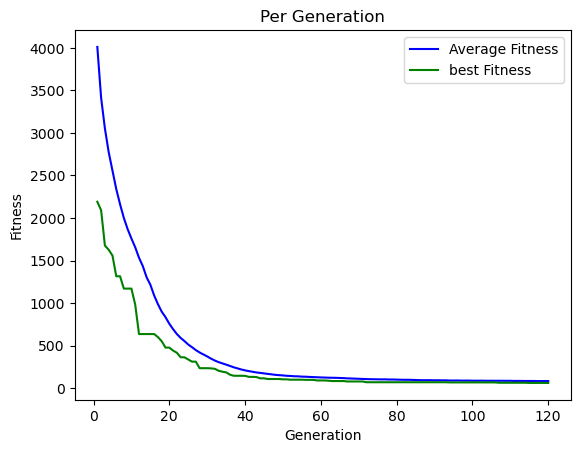

In [24]:
plt.figure()
plt.plot(range(1, ra.max_generations + 1), average_fitness_values, label='Average Fitness', color='blue')
plt.plot(range(1, ra.max_generations + 1), best_fitness_values, label='best Fitness', color='green')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Per Generation')
plt.legend()
plt.show()